### Technical Demonstration ACID operations - Delta Lake

In [1]:
# Import SparkSession (main entry point to Spark) and PySpark SQL functions
from pyspark.sql import SparkSession, functions as F
#from delta import configure_spark_with_delta_pip # (optional: only needed if you use pip-based Delta setup)

# Create or get an existing SparkSession
# This is how we initialize Spark in Python so we can read/write data, run SQL queries, etc.
spark = (SparkSession.builder
         # Give the Spark application a name
         .appName("ACID")
         # Enable Delta Lake support in this Spark session.
         # This tells Spark to load Delta’s SQL extensions (ACID, MERGE, UPDATE, DELETE, etc.)
         .config("spark.sql.extensions","io.delta.sql.DeltaSparkSessionExtension")
         # Replace Spark’s default catalog with Delta’s catalog,
         # so operations like spark.read.table(), CREATE TABLE, etc. understand Delta tables.
         .config("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog")
         # Build and return the SparkSession object.
         # If a session already exists, Spark reuses it.
         .getOrCreate())

25/10/12 15:02:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# Load a structured dataset (the wine-quality CSV) into a Spark DataFrame,
df = spark.read.csv("/CA1/ACID/winequality-red.csv", header = True, inferSchema = True, sep = ";")
# Bring data to memory, cache the data
df.cache()

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int]

In [3]:
# It is an action in spark, creates a spark job and count 
# all the rows using parallel processing (it is controlled by Spark) across the cpu cores in the local machine
df.count()

1599

In [4]:
# Shows the dataFrame schema (columns + types)
df

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int]

###### Check for Nulls in the dataset

In [5]:
# Check for null values
# For each column c, create a new column named c that contains the number of null values in that column.
df_result = df.select([
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
])

# Convert to pandas for a better visualisation
df_result_pd = df_result.toPandas().T  # Transpose for vertical display
df_result_pd.columns = ["null_count"] # Add column name null count
display(df_result_pd)

,null_count
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


###### Check for Duplicate rows in the dataset

In [6]:
# Find duplicates rows
total_rows = df.count()
unique_rows = df.dropDuplicates().count()
duplicates = total_rows - unique_rows

print(f"Total rows: {total_rows}")
print(f"Unique rows: {unique_rows}")
print(f"Duplicate rows: {duplicates}")

Total rows: 1599
Unique rows: 1359
Duplicate rows: 240


In [7]:
# Delete duplicates
df = df.dropDuplicates()

In [8]:
# Find duplicates rows
total_rows = df.count() # total number of rows
unique_rows = df.dropDuplicates().count() # number of distinct rows, after removing duplicates only one copy of each unique record remains.
duplicates = total_rows - unique_rows # duplicates

print(f"Total rows: {total_rows}")
print(f"Unique rows: {unique_rows}")
print(f"Duplicate rows: {duplicates}")

Total rows: 1359
Unique rows: 1359
Duplicate rows: 0


###### Prepare the dataset for inserting a row and for training neural network models. A copy of an existing row is created and modified (its label changed) and then inserted in the dataset to demonstrate that this lakehouse architecture (Delta Lake) does support ACID transactions.

In [9]:
# Add a column id + column label (quality >= 7 -> good wine)
df = (df.withColumn("id", F.monotonically_increasing_id())
         .withColumn("label", (F.col("quality") >= 7).cast("int")))

In [10]:
# Shows the new dataFrame schema (columns + types) after adding columns id and label
df

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int, id: bigint, label: int]

In [11]:
# select -> This is a transformation, meaning Spark is defining what you want to do 
# (create a new logical plan), but not executing it yet. In other words, 
# create a new logical DataFrame that only keeps these three columns: id, label, and quality
# show -> this is the action that triggers Spark to actually execute the plan
df.select("id", "label", "quality").show()

+---+-----+-------+
| id|label|quality|
+---+-----+-------+
|  0|    0|      4|
|  1|    0|      5|
|  2|    1|      7|
|  3|    1|      7|
|  4|    0|      6|
|  5|    0|      5|
|  6|    0|      5|
|  7|    1|      7|
|  8|    0|      5|
|  9|    0|      6|
| 10|    0|      6|
| 11|    0|      5|
| 12|    0|      6|
| 13|    0|      6|
| 14|    0|      6|
| 15|    1|      7|
| 16|    0|      6|
| 17|    0|      5|
| 18|    1|      7|
| 19|    1|      8|
+---+-----+-------+
only showing top 20 rows



In [12]:
# reorganize the dataframe, removing the column quality
# Python list comprehension with all the columns removing id, quality and label 
feature_cols = [c for c in df.columns if c not in ("id", "quality", "label")]
# add the id column at the beggining and label at the end
df = df.select("id", *feature_cols, "label")

In [13]:
# Return a Python list containing the names of all the columns in the spark dataFrame, in order.
df.columns

['id',
 'fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'label']

In [14]:
# shuffle the dataframe using a seed (always the same order), then select the first element.
# then return a list with one element. [0] returns the first row of that list  
row = df.orderBy(F.rand(42)).limit(1).collect()[0]
# return the id
bad_id = row["id"]
# return the label for that row
orig_label = row["label"]
# I change the label
fix_label = 1 - orig_label

In [15]:
# build a condition id == bad_id
cond = F.col("id") == bad_id
# .withColumn()-> adds or replaces a column, transofrmation
# F.lit(fix_label)-> creates a literal constant value for every row
# where() -> tells Spark which rows you want, transformation
# From DataFrame df, take the rows that satisfy cond,
# and assign (or overwrite) their label column with the constant value fix_label
row_fix = df.where(cond).withColumn("label", F.lit(fix_label))

###### The following two rows have identical feature values but different labels

In [16]:
# Convert that Spark Row object into a Python dictionary
print(row.asDict())

{'id': 255, 'fixed acidity': 8.9, 'volatile acidity': 0.875, 'citric acid': 0.13, 'residual sugar': 3.45, 'chlorides': 0.088, 'free sulfur dioxide': 4.0, 'total sulfur dioxide': 14.0, 'density': 0.9994, 'pH': 3.44, 'sulphates': 0.52, 'alcohol': 11.5, 'label': 0}


In [17]:
print(row_fix.first().asDict())

{'id': 255, 'fixed acidity': 8.9, 'volatile acidity': 0.875, 'citric acid': 0.13, 'residual sugar': 3.45, 'chlorides': 0.088, 'free sulfur dioxide': 4.0, 'total sulfur dioxide': 14.0, 'density': 0.9994, 'pH': 3.44, 'sulphates': 0.52, 'alcohol': 11.5, 'label': 1}


###### Delta Lake (CLEAN): MERGE upsert -> support ACID properties

In [18]:
# These are characters that I don’t want to appear in the column names.
# replace fixed acidity by fixed_acidity
bad_chars = [' ', ',', ';', '{', '}', '(', ')', '\n', '\t', '=']

def sanitize(name: str) -> str:
    out = name.strip() # Remove whitespace at start and end
    for ch in bad_chars:
        out = out.replace(ch, '_') # Replace every unwanted character (bad_chars) with _
    return out.lower() # Convert the name to lowercase and return it.

# Create a new dataFrame with those cleaned column names.
df = df.toDF(*[sanitize(c) for c in df.columns])

# Write in Delta Lake format (transactional Parquet files) and overwrite any file in that location.
df.write.format("delta").mode("overwrite").save("/CA1/ACID/clean/winequality-red")

In [19]:
# DeltaTable is a Delta Lake abstraction on top of Parquet data
# It gives you access to ACID operations (Delta Lake API)
from delta.tables import DeltaTable
# Open an existing Delta table from the path, It needs the active SparkSession (spark) 
# to interact with the metadata and files
delta_tbl = DeltaTable.forPath(spark, "/CA1/ACID/clean/winequality-red")

In [20]:
# Convert the delta table object (delta_tbl) into a regular spark dataFrame.
# filter by cond, selects id and label, and display it.
delta_tbl.toDF().filter(cond).select("id", "label").show()


25/10/12 15:08:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+-----+
| id|label|
+---+-----+
|255|    0|
+---+-----+



In [21]:
from delta.tables import DeltaTable

bad_chars = [' ', ',', ';', '{', '}', '(', ')', '\n', '\t', '=']
def sanitize(name: str) -> str:
    out = name.strip()
    for ch in bad_chars:
        out = out.replace(ch, '_')
    return out.lower()

# Create a new dataFrame with those cleaned column names. This dataframe has only
# one row, the one which has the label changed 
row_fix_aligned = row_fix.toDF(*[sanitize(c) for c in row_fix.columns])

# This operations is called UPSERT, because If it exists, update it. If it doesn’t exist, insert it.
# whenMatchedUpdateAll() -> if a match is found, update all the columns
# whenNotMatchedInsertAll() -> if a match is not found, insert the entire row
# ACID support
delta_tbl.alias("t").merge(
    row_fix_aligned.alias("s"),
    "t.id = s.id"
).whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()


In [22]:
# Convert the delta table object (delta_tbl) into a regular spark dataFrame.
# filter by cond, selects id and label, and display it.
delta_tbl.toDF().filter(cond).select("id", "label").show()

+---+-----+
| id|label|
+---+-----+
|255|    1|
+---+-----+



In [23]:
print("Delta CLEAN — single correct row for chosen id:")
spark.read.format("delta").load("/CA1/ACID/clean/winequality-red").select("id", "label").where(F.col("id")==bad_id).show()

Delta CLEAN — single correct row for chosen id:
+---+-----+
| id|label|
+---+-----+
|255|    1|
+---+-----+



In [26]:
print("CLEAN table version 0 (before MERGE):")
spark.read.format("delta").option("versionAsOf",0).load("/CA1/ACID/clean/winequality-red").select("id", "label").where(F.col("id")==bad_id).show()

CLEAN table version 0 (before MERGE):


+---+-----+
| id|label|
+---+-----+
|255|    0|
+---+-----+



In [27]:
spark.read.format("delta").option("versionAsOf", 0).load("/CA1/ACID/clean/winequality-red").count()


1359

In [30]:
spark.read.format("delta").option("versionAsOf", 1).load("/CA1/ACID/clean/winequality-red").count()


1359

### Train Keras ANN

In [31]:
#!pip install pandas numpy scikit-learn tensorflow

In [32]:
# import libraries to train ANN
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

2025-10-12 15:44:21.766322: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-12 15:44:23.432873: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-12 15:44:27.539245: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [30]:
# This list names the input columns — the variables that the model will use to make predictions
feature_cols = [
    "fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar",
    "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide",
    "density", "ph", "sulphates", "alcohol"
]

# this function takes a spark dataframe, as input and returns 
# NumPy arrays (X, y) — the standard format expected by TensorFlow
def to_numpy(sdf):
    # This collects the entire spark dataFrame into memory as a pandas dataFrame, it is an action
    # Trigger Spark to execute a job and produce a result.
    pdf = sdf.toPandas()
    # Select only the columns in the list above, and convert those Pandas columns into a 2D NumPy array
    # the data is stored as 32-bit floats (what TensorFlow expects).
    X = pdf[feature_cols].to_numpy(dtype=np.float32)
    # Select the label column and Converts it to a 1D NumPy array of integers
    y = pdf["label"].to_numpy(dtype=np.int64)
    return X, y

#### Train ANN with the dataframe which has the row with the label changed 

In [31]:
# Convert the delta table object (delta_tbl) into a regular spark dataFrame.
clean_df = delta_tbl.toDF()

In [32]:
# Check the new version contains the changed label 
clean_df.select("id", "label").where(cond).show()

+---+-----+
| id|label|
+---+-----+
|255|    1|
+---+-----+



In [33]:
# Check how many 0s and 1s are in the dataset using Spark
clean_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  185|
|    0| 1174|
+-----+-----+



In [34]:
# call the function to_numpy
X, y = to_numpy(clean_df)

In [35]:
# Check how many 0s and 1s are in the dataset using numpy
unique, counts = np.unique(y, return_counts=True) 
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(1174), np.int64(1): np.int64(185)}


In [36]:
# Split dataset into training and testing subsets
# test_size= 0.2 -> 20% of the data will go to the test set, and 80% will go to the training set
# If you have 1,599 samples: Training set is ~1,279 rows and Test set is 320 rows approximately
# Ensure the same split every time you run the code, otherwise different 20% of rows go to X_test each time 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [37]:
# Wrap the NumPy array X_train inside a pandas dataFrame to call describe
# we check values min and max to verify if they have different scales
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000
mean,8.338547,0.530603,0.271739,2.527691,0.088157,16.013340,46.659153,0.996735,3.309908,0.656734,10.439558
std,1.730869,0.185112,0.195892,1.374252,0.049906,10.605497,32.942955,0.001863,0.153877,0.161211,1.069283
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.370000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,13.000000,38.000000,0.996700,3.310000,0.620000,10.200000
75%,9.300000,0.642500,0.430000,2.600000,0.091000,22.000000,62.000000,0.997860,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


In [38]:
print(X_train.shape, X_test.shape)

(1087, 11) (272, 11)


In [39]:
# we standardize because different features have different scales, and we want them all to 
# have equal importance for the model
# fit on the training set, use the same mean and std from training data to scale the test set
# it means that both datasets are on the same scale
sc = StandardScaler().fit(X_train)
X_train, X_test = sc.transform(X_train), sc.transform(X_test)

###### First Model

In [40]:
# import libraries from tensorflow
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, LeakyReLU


# build a model with two hidden layers
# Dense -> fully connected layer (each neuron connects to every neuron in the next layer)
# d is the number of input features
# activation function relu for both hidden layers
# The output layer has one neuron because it is a binary classification (good wine vs bad wine)
# The activation function is sigmoid, so the network outputs is a probability: 
# close to 0 -> class 0 (bad wine)
# close to 1 -> class 1 (good wine)
# optimizer adam -> to adjusts learning rates during training
# loss binary_crossentropy -> used for binary classification
# metric accuracy -> to measure performance
def build_model(d):
    model = Sequential()
    # Input + Hidden Layer 1
    model.add(Dense(64, input_dim=d, activation="relu"))
    
    # Hidden Layer 2
    model.add(Dense(32, activation="relu"))
    
    # Output Layer    
    model.add(Dense(1, activation="sigmoid"))
    
    # Compile
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model
    
    #model = Sequential()
    #model.add(Dense(64, input_dim=d))
    #model.add(LeakyReLU(alpha=0.01))   # add activation as a layer
    #model.add(Dense(32))
    #model.add(LeakyReLU(alpha=0.01))
    #model.add(Dense(1, activation="sigmoid"))
    #model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    #return model

###### Second Model (includes techniques to improve training and generalization)

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# build a model with two hidden layers
# Dense -> fully connected layer (each neuron connects to every neuron in the next layer)
# d is the number of input features
# activation function relu for both hidden layers
# The output layer has one neuron because it is a binary classification (good wine vs bad wine)
# The activation function is sigmoid, so the network outputs is a probability: 
# close to 0 -> class 0 (bad wine)
# close to 1 -> class 1 (good wine)
# optimizer adam -> to adjusts learning rates during training
# loss binary_crossentropy -> used for binary classification
# metric accuracy -> to measure performance
# Three core techniques were added to make neural networks train better and 
# generalize well (Dropout, BatchNormalization and L2)
# EarlyStopping and ReduceLROnPlateau are callbacks that help your model train smarter 
# and avoid overfitting or wasting epochs
def build_model1(d):
    
    model = Sequential()
    # Input + Hidden Layer 1
    model.add(Dense(64, input_dim=d, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Hidden Layer 2
    model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Output Layer
    model.add(Dense(1, activation="sigmoid"))
    
    # Compile
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model
    
    #model = Sequential()
    
    # Input + Hidden Layer 1
    #model.add(Dense(64, input_dim=d, kernel_regularizer=l2(0.001)))
    #model.add(LeakyReLU(alpha=0.01))         # Replaces ReLU
    #model.add(BatchNormalization())
    #model.add(Dropout(0.3))
    
    # Hidden Layer 2
    #model.add(Dense(32, kernel_regularizer=l2(0.001)))
    #model.add(LeakyReLU(alpha=0.01))         # Replaces ReLU
    #model.add(BatchNormalization())
    #model.add(Dropout(0.3))
    
    # Output Layer
    #model.add(Dense(1, activation="sigmoid"))
    
    # Compile
    #model.compile(
    #    optimizer="adam",
    #    loss="binary_crossentropy",
    #    metrics=["accuracy"]
    #)
    #return model
    
    
es  = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5)

###### Training with the first model

In [42]:
# build the model
model = build_model(X_train.shape[1])
# trains the neural network
# epochs = 200 -> Feeds training data through the model 200 times
# give the model unseen data (validation data) to evaluate after each epoch
# the model trains on mini-batches of 16 examples at a time
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=16, verbose=2) # -> Model 1

/home/hduser/venvs/spark-delta/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-11 14:50:56.523711: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/200
68/68 - 1s - 17ms/step - accuracy: 0.8537 - loss: 0.4307 - val_accuracy: 0.8603 - val_loss: 0.3560
Epoch 2/200
68/68 - 0s - 6ms/step - accuracy: 0.8675 - loss: 0.3039 - val_accuracy: 0.8824 - val_loss: 0.3097
Epoch 3/200
68/68 - 0s - 3ms/step - accuracy: 0.8767 - loss: 0.2789 - val_accuracy: 0.8934 - val_loss: 0.2918
Epoch 4/200
68/68 - 0s - 3ms/step - accuracy: 0.8841 - loss: 0.2699 - val_accuracy: 0.8971 - val_loss: 0.2915
Epoch 5/200
68/68 - 0s - 3ms/step - accuracy: 0.8813 - loss: 0.2619 - val_accuracy: 0.8934 - val_loss: 0.2753
Epoch 6/200
68/68 - 0s - 3ms/step - accuracy: 0.8868 - loss: 0.2574 - val_accuracy: 0.9007 - val_loss: 0.2786
Epoch 7/200
68/68 - 0s - 3ms/step - accuracy: 0.8832 - loss: 0.2566 - val_accuracy: 0.9044 - val_loss: 0.2750
Epoch 8/200
68/68 - 0s - 3ms/step - accuracy: 0.8924 - loss: 0.2502 - val_accuracy: 0.9081 - val_loss: 0.2803
Epoch 9/200
68/68 - 0s - 5ms/step - accuracy: 0.8905 - loss: 0.2473 - val_accuracy: 0.9044 - val_loss: 0.2824
Epoch 10/

Epoch 75/200
68/68 - 0s - 3ms/step - accuracy: 0.9604 - loss: 0.1061 - val_accuracy: 0.8713 - val_loss: 0.4291
Epoch 76/200
68/68 - 0s - 2ms/step - accuracy: 0.9660 - loss: 0.1024 - val_accuracy: 0.9044 - val_loss: 0.4298
Epoch 77/200
68/68 - 0s - 3ms/step - accuracy: 0.9614 - loss: 0.1049 - val_accuracy: 0.9044 - val_loss: 0.4190
Epoch 78/200
68/68 - 0s - 3ms/step - accuracy: 0.9614 - loss: 0.1008 - val_accuracy: 0.8934 - val_loss: 0.4301
Epoch 79/200
68/68 - 0s - 3ms/step - accuracy: 0.9650 - loss: 0.0989 - val_accuracy: 0.8934 - val_loss: 0.4483
Epoch 80/200
68/68 - 0s - 5ms/step - accuracy: 0.9632 - loss: 0.0981 - val_accuracy: 0.8934 - val_loss: 0.4500
Epoch 81/200
68/68 - 0s - 5ms/step - accuracy: 0.9660 - loss: 0.0957 - val_accuracy: 0.9044 - val_loss: 0.4456
Epoch 82/200
68/68 - 0s - 3ms/step - accuracy: 0.9678 - loss: 0.0944 - val_accuracy: 0.9044 - val_loss: 0.4512
Epoch 83/200
68/68 - 0s - 3ms/step - accuracy: 0.9660 - loss: 0.0912 - val_accuracy: 0.8750 - val_loss: 0.5036
E

Epoch 149/200
68/68 - 0s - 3ms/step - accuracy: 0.9963 - loss: 0.0255 - val_accuracy: 0.8897 - val_loss: 0.6714
Epoch 150/200
68/68 - 0s - 6ms/step - accuracy: 0.9972 - loss: 0.0265 - val_accuracy: 0.8860 - val_loss: 0.6780
Epoch 151/200
68/68 - 0s - 3ms/step - accuracy: 0.9963 - loss: 0.0240 - val_accuracy: 0.8787 - val_loss: 0.7260
Epoch 152/200
68/68 - 0s - 5ms/step - accuracy: 0.9936 - loss: 0.0247 - val_accuracy: 0.8897 - val_loss: 0.6852
Epoch 153/200
68/68 - 0s - 3ms/step - accuracy: 0.9963 - loss: 0.0266 - val_accuracy: 0.9044 - val_loss: 0.6566
Epoch 154/200
68/68 - 0s - 4ms/step - accuracy: 0.9972 - loss: 0.0244 - val_accuracy: 0.8934 - val_loss: 0.6918
Epoch 155/200
68/68 - 0s - 3ms/step - accuracy: 0.9963 - loss: 0.0220 - val_accuracy: 0.8971 - val_loss: 0.7110
Epoch 156/200
68/68 - 0s - 3ms/step - accuracy: 0.9972 - loss: 0.0229 - val_accuracy: 0.8971 - val_loss: 0.7253
Epoch 157/200
68/68 - 0s - 5ms/step - accuracy: 0.9945 - loss: 0.0247 - val_accuracy: 0.8787 - val_loss:

###### Training with the second model

In [43]:
# build the model
model1 = build_model1(X_train.shape[1])
# trains the neural network
# epochs = 200 -> Feeds training data through the model 200 times
# give the model unseen data (validation data) to evaluate after each epoch
# the model trains on mini-batches of 16 examples at a time
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=16, verbose=2, callbacks=[es, rlr]) # -> Model 2

Epoch 1/200
68/68 - 2s - 29ms/step - accuracy: 0.6081 - loss: 0.7775 - val_accuracy: 0.8382 - val_loss: 0.6094 - learning_rate: 1.0000e-03
Epoch 2/200
68/68 - 0s - 4ms/step - accuracy: 0.7369 - loss: 0.6007 - val_accuracy: 0.8750 - val_loss: 0.5336 - learning_rate: 1.0000e-03
Epoch 3/200
68/68 - 0s - 3ms/step - accuracy: 0.7912 - loss: 0.5312 - val_accuracy: 0.8603 - val_loss: 0.4670 - learning_rate: 1.0000e-03
Epoch 4/200
68/68 - 0s - 3ms/step - accuracy: 0.8372 - loss: 0.4565 - val_accuracy: 0.8750 - val_loss: 0.4186 - learning_rate: 1.0000e-03
Epoch 5/200
68/68 - 0s - 3ms/step - accuracy: 0.8482 - loss: 0.4173 - val_accuracy: 0.8860 - val_loss: 0.3838 - learning_rate: 1.0000e-03
Epoch 6/200
68/68 - 1s - 8ms/step - accuracy: 0.8602 - loss: 0.3885 - val_accuracy: 0.8860 - val_loss: 0.3555 - learning_rate: 1.0000e-03
Epoch 7/200
68/68 - 0s - 5ms/step - accuracy: 0.8500 - loss: 0.4019 - val_accuracy: 0.8787 - val_loss: 0.3498 - learning_rate: 1.0000e-03
Epoch 8/200
68/68 - 0s - 4ms/step

#### Train ANN with the dataframe which has the row with the right label 

In [44]:
# get from Hadoop the version with the old label
clean_old_df = spark.read.format("delta").option("versionAsOf", 0).load("/CA1/ACID/clean/winequality-red")

In [45]:
# Replace invalid characters with underscores, sanitize the columns
for c in clean_old_df.columns:
    clean_old_df = clean_old_df.withColumnRenamed(c, c.strip().lower().replace(" ", "_"))

In [46]:
# check if the old version has the label with the old value, it is 0, so it is correct
clean_old_df.select("id", "label").where(F.col("id")==bad_id).show()

+---+-----+
| id|label|
+---+-----+
|255|    0|
+---+-----+



In [47]:
# Check how many 0s and 1s are in the dataset using Spark
clean_old_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  184|
|    0| 1175|
+-----+-----+



In [48]:
# call the function to_numpy
X1, y1 = to_numpy(clean_old_df)

In [49]:
# Check how many 0s and 1s are in the dataset using numpy
unique, counts = np.unique(y, return_counts=True) 
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(1174), np.int64(1): np.int64(185)}


In [50]:
# Split dataset into training and testing subsets
# test_size= 0.2 -> 20% of the data will go to the test set, and 80% will go to the training set
# If you have 1,599 samples: Training set is ~1,279 rows and Test set is 320 rows approximately
# Ensure the same split every time you run the code, otherwise different 20% of rows go to X_test1 each time 
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=7)

In [51]:
#from sklearn.utils import resample
#import pandas as pd

#dfnew = pd.DataFrame(X_train1,columns=feature_cols)
#dfnew['label'] = y_train1

#majority = dfnew[dfnew.label == 0]
#minority = dfnew[dfnew.label == 1]

#minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
#df_balanced = pd.concat([majority, minority_upsampled])

# Shuffle the dataset to mix both classes
#df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

#X_train1 = df_balanced[feature_cols].to_numpy(dtype=np.float32)
#y_train1 = df_balanced["label"].to_numpy(dtype=np.int64)


In [52]:
# Wrap the NumPy array X_train1 inside a pandas dataFrame to call describe
# we check values min and max to verify if they have different scales
pd.DataFrame(X_train1).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000,1087.000000
mean,8.338547,0.530603,0.271739,2.527691,0.088157,16.013340,46.659153,0.996735,3.309908,0.656734,10.439558
std,1.730869,0.185112,0.195892,1.374252,0.049906,10.605497,32.942955,0.001863,0.153877,0.161211,1.069283
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.370000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,13.000000,38.000000,0.996700,3.310000,0.620000,10.200000
75%,9.300000,0.642500,0.430000,2.600000,0.091000,22.000000,62.000000,0.997860,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


In [53]:
print(X_train1.shape, X_test1.shape)

(1087, 11) (272, 11)


In [54]:
# we standardize because different features have different scales, and we want them all to have equal importance for the model.
# fit on the training set, use the same mean and std from training data to scale the test set
# it means that both datasets are on the same scale
sc = StandardScaler().fit(X_train1)
X_train1, X_test1 = sc.transform(X_train1), sc.transform(X_test1)

In [55]:
#from sklearn.utils.class_weight import compute_class_weight
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train1), y=y_train1)
#class_weights = dict(enumerate(class_weights))
#print(class_weights)

###### Training with the first model

In [56]:
# build the model
model = build_model(X_train1.shape[1])
# trains the neural network
# epochs = 200 -> Feeds training data through the model 200 times
# give the model unseen data (validation data) to evaluate after each epoch
# the model trains on mini-batches of 16 examples at a time
history = model.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs=200, batch_size=16, verbose=2) # <- Model 1

Epoch 1/200


/home/hduser/venvs/spark-delta/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


68/68 - 1s - 14ms/step - accuracy: 0.8611 - loss: 0.3795 - val_accuracy: 0.8750 - val_loss: 0.3376
Epoch 2/200
68/68 - 0s - 3ms/step - accuracy: 0.8841 - loss: 0.2956 - val_accuracy: 0.8860 - val_loss: 0.3012
Epoch 3/200
68/68 - 0s - 3ms/step - accuracy: 0.8795 - loss: 0.2767 - val_accuracy: 0.8897 - val_loss: 0.2879
Epoch 4/200
68/68 - 0s - 4ms/step - accuracy: 0.8822 - loss: 0.2675 - val_accuracy: 0.8934 - val_loss: 0.2747
Epoch 5/200
68/68 - 0s - 5ms/step - accuracy: 0.8850 - loss: 0.2622 - val_accuracy: 0.8934 - val_loss: 0.2800
Epoch 6/200
68/68 - 0s - 3ms/step - accuracy: 0.8924 - loss: 0.2567 - val_accuracy: 0.9007 - val_loss: 0.2719
Epoch 7/200
68/68 - 0s - 3ms/step - accuracy: 0.8887 - loss: 0.2522 - val_accuracy: 0.8860 - val_loss: 0.2824
Epoch 8/200
68/68 - 0s - 2ms/step - accuracy: 0.8850 - loss: 0.2503 - val_accuracy: 0.9007 - val_loss: 0.2632
Epoch 9/200
68/68 - 0s - 3ms/step - accuracy: 0.8905 - loss: 0.2459 - val_accuracy: 0.9044 - val_loss: 0.2622
Epoch 10/200
68/68 - 

Epoch 75/200
68/68 - 1s - 20ms/step - accuracy: 0.9660 - loss: 0.0950 - val_accuracy: 0.8971 - val_loss: 0.3339
Epoch 76/200
68/68 - 0s - 4ms/step - accuracy: 0.9669 - loss: 0.0969 - val_accuracy: 0.9044 - val_loss: 0.3640
Epoch 77/200
68/68 - 0s - 3ms/step - accuracy: 0.9706 - loss: 0.0903 - val_accuracy: 0.9044 - val_loss: 0.3483
Epoch 78/200
68/68 - 0s - 3ms/step - accuracy: 0.9752 - loss: 0.0872 - val_accuracy: 0.8824 - val_loss: 0.3715
Epoch 79/200
68/68 - 0s - 3ms/step - accuracy: 0.9687 - loss: 0.0868 - val_accuracy: 0.8934 - val_loss: 0.3778
Epoch 80/200
68/68 - 0s - 5ms/step - accuracy: 0.9706 - loss: 0.0890 - val_accuracy: 0.9007 - val_loss: 0.3664
Epoch 81/200
68/68 - 0s - 3ms/step - accuracy: 0.9752 - loss: 0.0843 - val_accuracy: 0.9044 - val_loss: 0.3486
Epoch 82/200
68/68 - 0s - 3ms/step - accuracy: 0.9752 - loss: 0.0833 - val_accuracy: 0.9044 - val_loss: 0.4008
Epoch 83/200
68/68 - 0s - 5ms/step - accuracy: 0.9706 - loss: 0.0852 - val_accuracy: 0.9007 - val_loss: 0.3770


Epoch 149/200
68/68 - 0s - 3ms/step - accuracy: 0.9945 - loss: 0.0269 - val_accuracy: 0.8750 - val_loss: 0.6129
Epoch 150/200
68/68 - 0s - 5ms/step - accuracy: 0.9890 - loss: 0.0385 - val_accuracy: 0.8860 - val_loss: 0.6414
Epoch 151/200
68/68 - 0s - 2ms/step - accuracy: 0.9926 - loss: 0.0299 - val_accuracy: 0.8897 - val_loss: 0.6028
Epoch 152/200
68/68 - 0s - 3ms/step - accuracy: 0.9963 - loss: 0.0208 - val_accuracy: 0.8787 - val_loss: 0.6238
Epoch 153/200
68/68 - 0s - 3ms/step - accuracy: 0.9954 - loss: 0.0233 - val_accuracy: 0.8824 - val_loss: 0.6347
Epoch 154/200
68/68 - 0s - 3ms/step - accuracy: 0.9954 - loss: 0.0224 - val_accuracy: 0.8934 - val_loss: 0.5779
Epoch 155/200
68/68 - 0s - 5ms/step - accuracy: 0.9963 - loss: 0.0224 - val_accuracy: 0.8750 - val_loss: 0.5989
Epoch 156/200
68/68 - 0s - 3ms/step - accuracy: 0.9972 - loss: 0.0198 - val_accuracy: 0.8860 - val_loss: 0.5492
Epoch 157/200
68/68 - 0s - 3ms/step - accuracy: 0.9991 - loss: 0.0188 - val_accuracy: 0.8897 - val_loss:

###### Training with the second model

In [60]:
# build the model
model1 = build_model1(X_train1.shape[1])
# trains the neural network
# epochs = 200 -> Feeds training data through the model 200 times
# give the model unseen data (validation data) to evaluate after each epoch
# the model trains on mini-batches of 16 examples at a time
history1 = model1.fit(X_train1, y_train1, validation_data=(X_test1, y_test1), epochs=200, batch_size=16, verbose=2, callbacks=[es, rlr]) # <- Model 2

Epoch 1/200
68/68 - 2s - 23ms/step - accuracy: 0.5906 - loss: 0.8086 - val_accuracy: 0.8456 - val_loss: 0.5862 - learning_rate: 1.0000e-03
Epoch 2/200
68/68 - 0s - 5ms/step - accuracy: 0.7360 - loss: 0.6272 - val_accuracy: 0.8676 - val_loss: 0.5073 - learning_rate: 1.0000e-03
Epoch 3/200
68/68 - 0s - 3ms/step - accuracy: 0.7866 - loss: 0.5291 - val_accuracy: 0.8824 - val_loss: 0.4447 - learning_rate: 1.0000e-03
Epoch 4/200
68/68 - 0s - 5ms/step - accuracy: 0.8399 - loss: 0.4627 - val_accuracy: 0.8934 - val_loss: 0.3953 - learning_rate: 1.0000e-03
Epoch 5/200
68/68 - 0s - 3ms/step - accuracy: 0.8464 - loss: 0.4280 - val_accuracy: 0.8897 - val_loss: 0.3801 - learning_rate: 5.0000e-04
Epoch 6/200
68/68 - 0s - 3ms/step - accuracy: 0.8362 - loss: 0.4368 - val_accuracy: 0.8971 - val_loss: 0.3626 - learning_rate: 5.0000e-04
Epoch 7/200
68/68 - 0s - 3ms/step - accuracy: 0.8556 - loss: 0.4180 - val_accuracy: 0.8971 - val_loss: 0.3498 - learning_rate: 5.0000e-04
Epoch 8/200
68/68 - 0s - 3ms/step

In [73]:
# Save model to Disk
#json_file_path = "/home/hduser/wine_model.json"
#h5_file_path = "/home/hduser/wine_model.weights.h5"

#model_json = model1.to_json()
#with open(json_file_path, "w") as json_file:
#    json_file.write(model_json)
    
#print(f"Model architecture save to: {json_file_path}")    

#model.save_weights(h5_file_path)
#print(f"Model weights saved to: {h5_file_path}")

###### Results for the second model

In [62]:
# Make predictions on unseen data (X_test1)
# and then print the probabilities
predictions = model1.predict(X_test1).ravel()
print(predictions)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[0.31546634 0.48363853 0.32154843 0.3077991  0.50754267 0.32467946
 0.36066997 0.48754048 0.2523761  0.4111126  0.50571984 0.47470048
 0.404102   0.4572613  0.349301   0.42418984 0.40078115 0.35422388
 0.25409815 0.43357325 0.5174892  0.3665139  0.3312921  0.44488755
 0.33526313 0.51698226 0.34314454 0.5357081  0.37184915 0.4565899
 0.38029715 0.32754716 0.28073555 0.386036   0.5057764  0.3975875
 0.41790414 0.32279184 0.3698294  0.4510662  0.41404182 0.3373943
 0.54150796 0.3835834  0.33781686 0.40005243 0.5833386  0.37532374
 0.586886   0.44416663 0.40071827 0.52255255 0.33502144 0.3780922
 0.36502212 0.3893189  0.35417733 0.34855768 0.39475814 0.22891827
 0.20553063 0.34740582 0.38316396 0.42502883 0.41662905 0.3369473
 0.5049491  0.35864982 0.28458366 0.52423877 0.33570087 0.4804293
 0.54377896 0.49471498 0.29459456 0.36386842 0.3975265  0.31536353
 0.3961296  0.25583208 0.34269792 0.41935062 0.3566633  0.52371633
 0.36599943 0.5742148  0.25198

In [67]:
threshold = 0.46  # I can try with different threshold 0.3, 0.4, 0.5, etc.
pred = (predictions >= threshold).astype(int)
print(pred)

print("Pred type: ", type(pred)) 
print("Shape of pred: ", len(pred))
print("Dataset type: ", type(clean_old_df)) 


[0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1
 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 1 0 1 1 0 0 0 0 0]
Pred type:  <class 'numpy.ndarray'>
Shape of pred:  272
Dataset type:  <class 'pyspark.sql.dataframe.DataFrame'>


In [68]:
#pip install matplotlib

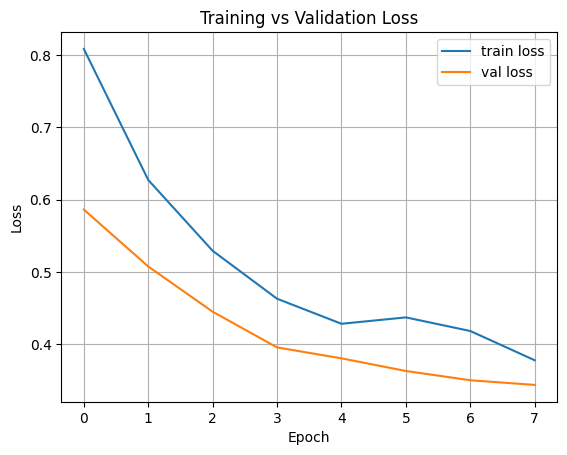

In [69]:
# Plot how the model learned over time (epoch by epoch).
# Keras returns a History object that stores the training progress
# history.history is a dictionary
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history1.history["loss"], label="train loss")
plt.plot(history1.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

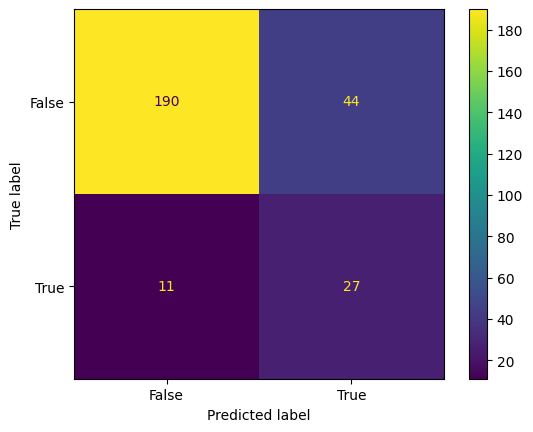

              precision    recall  f1-score   support

           0      0.945     0.812     0.874       234
           1      0.380     0.711     0.495        38

    accuracy                          0.798       272
   macro avg      0.663     0.761     0.684       272
weighted avg      0.866     0.798     0.821       272



In [72]:
# import libraries 
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# Confusion_matrix -> build the table comparing true vs predicted labels

cm = confusion_matrix(y_test1, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()
# Classification_report -> compute precision, recall, and F1-score.
print(classification_report(y_test1, pred, digits=3))

In [71]:
import sys, pyspark
import importlib.metadata

print("Python exe:", sys.executable)  # expect ~/venvs/spark-delta/bin/python
print("PySpark ver:", pyspark.__version__)
print("Delta Lake (delta-spark) version:", importlib.metadata.version("delta-spark"))

print("Spark:", spark.version)
print("JARs:", spark._jsc.sc().listJars().toString())  # expect delta-spark + delta-storage listed

Python exe: /home/hduser/venvs/spark-delta/bin/python
PySpark ver: 3.5.1
Delta Lake (delta-spark) version: 3.2.0
Spark: 3.5.6
JARs: Vector(spark://BDSP:35965/jars/delta-storage-3.2.0.jar, spark://BDSP:35965/jars/delta-spark_2.12-3.2.0.jar)
